# Projet  de Machine Learning en Python - Stratégie de Trading, NLP et Twitter

## Date : 06/02/2021
*Groupe : Léo PIACENTINO, Olivier NGO, Hugo MOREL*

*** 

## `Sujet :`
Étant tous les trois intéressés par le monde de la finance, nous voulions réaliser un projet de Machine Learning appliqué à ce domaine. Nous avons donc choisi de traiter un sujet de finance de marché se servant du **Natural Language Processing** comme projet. Ainsi, nous avons décidé d'essayer de créer une stratégie de trading profitable sur le Bitcoin en se servant du "Sentiment Analysis". Après mûre réflexion, se focaliser sur l'impact de **Twitter** sur le **cours du Bitcoin** semblait être le sujet le plus pertinent. En effet, nous supposons qu'il existe un lien entre la source d'information (tant officielle que parallèle) qu'est Twitter et le cours du Bitcoin. 

**Problématique : Est-il possible et viable d'analyser et d'interpréter des informations textuelles liées au Bitcoin, dans le but d'en déduire une position d'investissement à court/moyen-terme ?**

Pour répondre à notre problématique, nous nous sommes concentrés sur une analyse du **Bitcoin** par l'intermédiaire de deux sources d'information :

* son prix du 17-08-2017 jusqu'à aujourd'hui 02-02-2021
* la publication d'informations relatives au Bitcoin (Tweeter)


Les prix ont été récoltés avec **l'API Binance**, les informations relatives au Bitcoin ont été obtenues depuis les Tweets de personnes et entreprises considérées comme influentes dans le milieu de la cryptomonnaie avec **l'API Twitter**. Les personnes en question sont par exemple le créateur de l'Ethereum, des "crypto-trader" suivis par centaines de milliers ou encore les créateurs des "exchanges" et "brokers". 

*** 

## `Plan du projet :`

#### 1) Création des bases de données
* Récupération des Tweets avec **l'API Twitter**
* Récupération du prix du Bitcoin avec **l'API Binance**

#### 2) Data-Cleaning des données

* Retraitement des Tweets
* Retraitement des prix
* Fusion des bases de données

#### 3) Data-Visualiation

#### 4) NLP BERT & Hugging Face

#### 5) Backtest

#### 6) Conclusion 

*** 

In [1]:
from datetime import datetime
import pandas as pd

## 1) Création des bases de données

### A) Récupération des Tweets avec **l'API de Twitter**

Afin de créer une base de données cohérente, nous avons selectionnés 47 comptes Twitter de personnes et entreprises influentes dans le domaine des cryptomonnaies :


    - @Binance            - @Reuters             - @Officialmcafee        - @loomdart
    - @Coinbase           - @CNBC                - @VitalikButerin        - @Sicarious_
    - @Bitstamp           - @BespokeCrypto       - @pmarca                - @Cryptopathic
    - @MarketWatch        - @APompliano          - @rogerkver             - @CryptoHayes
    - @business           - @NickSzabo4          - @ToneVays              - @JihanWu
    - @YahooFinance       - @nic__carter         - @CharlieShrem          - @starkness
    - @TechCrunch         - @CarpeNoctom         - @naval                 - @brian_armstrong
    - @WSJ                - @Melt_Dem            - @tayvano_              - @BarrySilbert
    - @Forbes             - @100TrillionUSD      - @FEhrsam               - @jack
    - @FT                 - @MessariCrypto       - @ErikVoorhees          - @CryptoDonAlt
    - @TheEconomist       - @MartyBent           - @CryptoCobain          - @CryptoCred
    - @nytimes            - @aantonop            - @ThisIsNuse


De plus nous avons choisi de croiser les comptes ci-dessus avec une recherche par mots clés **["Bitcoin", "BTC"]**,
**dans le but d'obtenir des informations portant uniquement sur le Bitcoin.**

Pour commencer, précisons l'hypothèse derrière ce choix de comptes qui est un filtre sur l'information du Bitcoin. Nous remarquons qu'il est possible d'appréhender le sujet de deux façons différentes. Premièrement, d'aucuns pourraient vouloir récolter toute l'information disponible sous le **#Bitcoin**. Cette première approche implique une grande quantité de données mais de mauvaise qualité. En effet, le sujet du Bitcoin est presque devenu un sujet populaire où nombre de boursicoteurs spéculent sur son cours. Sous cette condition, les tweets sont généralement mal orthographiés, mal exprimés, pas assez concis et peu informatifs lorsqu'ils sont pris un à un (en revanche, il existe certainement un intérêt à aggréger par fênetres de temps le sentiment général, celui de la doxa). L'information récupérée à travers cette approche aurait permis d'analyser la fréquence et le volume des tweets tout en essayant d'aggréger un "Sentiment Analysis". Une seconde approche, qui est la nôtre, est de ne se focaliser que sur les utilisateurs clés, ayant un impact reconnu et notable sur le monde des cryptomonnaies et donc du Bitcoin. En effet, la plus part des investisseurs individuels spéculant sur le Bitcoin suivent avec grande attention les messages et conseils prodigués par ces "influenceurs financiers". Ils prennent leurs décisions d'investissement suite à certains de ces Tweets clés. Notre réflexion a donc été de prendre l'information à sa racine, au niveau des décideurs de tendances suivi par les investisseurs individuels et donc de dégager des signaux forts d'achat ou de vente. Ainsi, notre objectif est donc d'anticiper le mouvement de toute la communauté sur le cours en se focalisant sur les personnes qui guident cette communauté. 

#### Classe qui récupère les Tweets depuis l'API Twitter

In [2]:
from dataclasses import dataclass
from typing import List, Tuple
from tweepy import API # Bibliothèque de l'API Tweeter
import tweepy as tw 
import pandas as pd
from tqdm import tqdm
import re

@dataclass
class OAuthClient: 
    consumer_key: str = None
    consumer_secret: str = None
    access_token: str = None
    access_token_secret: str = None
    # check des paramètres pour qu'aucun ne soit None
    def __post_init__(self):
        if len(list(filter(lambda x: x is None or len(x) == 0, self.__dict__.values()))) > 0:
            raise RuntimeError("Missing parameters NoneType or Empty string") # gestion des exceptions

# utiliser pour filtrer la requête via l'API Twitter
@dataclass(frozen=True)
class Pagination:
    user_name: str
    hashtag: List[str]

    @classmethod
    def from_data(cls,
                  user_name: str,
                  hashtags: List[str]):

        if user_name and hashtags and len(user_name) > 0 and len(hashtags):
            return cls(*cls._format(user_name=user_name,
                                    hashtags=hashtags)
                       )
        else:
            raise RuntimeError("user_name is needed as hashtag to create pagination")

    @staticmethod
    def _format(user_name: str,
                hashtags: List[str]):

        return ["@" + user_name, list(str("#" + hashtag).upper() for hashtag in hashtags)]

# retourne la liste des paginations
class PaginationInitiator(Pagination):

    def __new__(cls,
                user_names: List[str],
                hashtags: List[str]
                ) -> List[Pagination]:
        """

        :param user_names:
        :param hashtags:
        :return list of pagination elements for Cursor Generation

        """

        return list(map(lambda x: Pagination.from_data(x, hashtags), user_names))


class CursorCallable(object):
    def __init__(self, cursor: tw.Cursor, pagination: Pagination):
        self._cursor = cursor
        self._pagination = pagination
        
    #/!\ méthode clée de la classe permettant de contourner la limite de téléchargement de l'API
    def __call__(self, *args, **kwargs) -> Tuple[str, List[tw.Status]]: 
        _cursor = tqdm(self._cursor.items(100000)) # Nombre maximum de Tweets à récolter
        return (self._pagination.user_name, list(item for item in _cursor if
                                                 any([substring in item.text.upper() for substring in
                                                      self._pagination.hashtag])))

# retourne la liste des curseurs
class CursorGenerator(object):

    def __new__(cls, api_session: API, pagination_list: List[Pagination]) -> List[CursorCallable]:
        """

        :param api_session:
        :param pagination_list: return a list of cursor to look for item
        """

        return list(
            CursorCallable(
                cursor=tw.Cursor(method=api_session.user_timeline,
                                 screen_name=pagination.user_name,
                                 since="2019-05-01"),
                pagination=pagination
            )
            for
            pagination in pagination_list
        )


class DataBaseBuilder(object):

    def __init__(self, oauth_client: OAuthClient):
        self._df = pd.DataFrame()
        self.tweets_old_df = None
        self._oauth_client = oauth_client
        self._api_session = API()
        self._list_of_status = list()
        DataBaseBuilder.__post_init__(self)

    @property
    def df(self):
        return self._df

    @property
    def api_session(self) -> API:
        return self._api_session

    @property
    def oauth_client(self):
        return self._oauth_client

    def __post_init__(self):
        self._auth()
        return self

    def _auth(self):
        """

        This method will instantiate a new session for REST call on API Twitter
        """
        _auth = tw.OAuthHandler(consumer_key=self._oauth_client.consumer_key,
                                consumer_secret=self._oauth_client.consumer_secret)
        _auth.set_access_token(key=self._oauth_client.access_token,
                               secret=self._oauth_client.access_token_secret)
        self._api_session = tw.API(auth_handler=_auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    def get_tweets(self, *args):
        return self._read_cursor(*args)

    def to_csv(self):
        self._build_df()
        self.df.to_csv("tweets_df.csv")

    def _build_df(self):
        for tweet in self._list_of_status:
            self._df = self._df.append(pd.DataFrame({'user_name': tweet.user.name,
                                                     'user_followers': tweet.user.followers_count,
                                                     'user_friends': tweet.user.friends_count,
                                                     'user_favourites': tweet.user.favourites_count,
                                                     'user_verified': tweet.user.verified,
                                                     'Date': tweet.created_at,
                                                     'Text': tweet.text,
                                                     'Like' : tweet.favorite_count,
                                                     'source': tweet.source,
                                                     'is_retweet': tweet.retweeted}, index=[0]))
        self._df.reset_index()

    def _read_cursor(self, *args):
        _cursors = CursorGenerator(api_session=self.api_session,
                                   pagination_list=PaginationInitiator(*args))

        _status_dict = dict(tuple((cursor() for cursor in _cursors)))
        self._list_of_status = [x for v in _status_dict.values() for x in v]
        return self



In [3]:
auth_client = OAuthClient(consumer_key="0VwCIq3X9FaBMqmLYmZAkamqK",
                          consumer_secret="bpUPtpdlly6tiY8Oj4AQYqvsVus4DdvfQ7OTmU2WpadQI61XrR",
                          access_token='1349043797003530242-AfZsuSU35jsN5QBw2Dy4TNWusXlD4l',
                          access_token_secret='OP6jVCy6m9yaoqQ8XxEqkKC7dprnE3Uup2Z7DXhnYp4te')
data = DataBaseBuilder(auth_client)

In [4]:
comptes_twitter = ['Binance','Coinbase', 'Bitstamp','MarketWatch','business','YahooFinance','TechCrunch',\
                   'WSJ','Forbes','FT','TheEconomist','nytimes','Reuters','CNBC','BespokeCrypto','APompliano',\
                   'NickSzabo4','nic__carter','CarpeNoctom','Melt_Dem','100TrillionUSD','MessariCrypto',\
                   'MartyBent','aantonop','Officialmcafee','VitalikButerin','pmarca','rogerkver','ToneVays',\
                   'CharlieShrem','naval','tayvano_','FEhrsam','ErikVoorhees','CryptoCobain','ThisIsNuse',\
                   'loomdart','Sicarious_','Cryptopathic','CryptoHayes','JihanWu','starkness','brian_armstrong',\
                   'BarrySilbert','jack','CryptoDonAlt','CryptoCred']

mots_cles = ["Bitcoin", "BTC"]

In [5]:
# Imporation des tweets dans une dataFrame
# tweets = data.get_tweets(comptes_twitter, mots_cles)
tweets = data.get_tweets(comptes_twitter, mots_cles)

3210it [01:06, 48.23it/s]
3211it [01:01, 52.08it/s]
3232it [01:05, 49.59it/s]
3239it [01:02, 52.14it/s]
3229it [01:01, 52.38it/s]
1681it [00:35, 29.04it/s]Rate limit reached. Sleeping for: 548
3226it [10:19,  5.21it/s]
3203it [01:04, 49.67it/s]
3228it [01:02, 51.46it/s]
3241it [01:02, 52.11it/s]
3241it [01:00, 53.33it/s]
3245it [01:00, 53.66it/s]
81it [00:01,  9.72it/s]Rate limit reached. Sleeping for: 556
3222it [10:26,  5.14it/s]
3215it [01:01, 52.60it/s]
3211it [01:01, 51.96it/s]
216it [00:04, 45.91it/s]
3244it [01:02, 52.21it/s]
3147it [01:07, 46.81it/s]
1561it [00:32, 53.99it/s]Rate limit reached. Sleeping for: 547
3235it [10:17,  5.24it/s]
3225it [01:10, 46.00it/s]
3236it [01:05, 49.27it/s]
3213it [01:04, 49.63it/s]
3245it [01:12, 44.84it/s]
3123it [01:16, 40.84it/s]
1it [00:00,  2.63it/s]Rate limit reached. Sleeping for: 517
3221it [09:50,  5.46it/s]
3234it [01:04, 49.83it/s]
3244it [01:03, 50.75it/s]
152it [00:03, 47.20it/s]
3218it [01:07, 47.58it/s]
3226it [01:06, 48.53it/s]
1

In [7]:
# Exportation des tweets sous le format d'un csv
tweets.to_csv()

#### Description du GetTweets

Pour commencer, nous avons dû créer en amont (dès l'attribution de notre sujet) un compte "Twitter Developper" pour pouvoir obtenir les clés API et les Tokens. Une fois la candidature acceptée, nous avons pu récupérer les Tweets. En revanche, l'API de Twitter Developper permet de recupérer uniquement 900 Tweets par 1/4 d'heure, ce qui peut vite devenir contraignant. Le code ci-dessus permet de "by-pass" cette limite en relançant l'instanciation d'une session pour appeler l'API Twitter. De plus, le tour de force de cette structure est de pouvoir combiner une requête sur les noms des utilisateurs ET des hashtags. De base, la bibliothèque de l'API de Twitter ne permet pas de faire une telle rêquete, elle permet uniquement de recupérer des Tweets par utilisateur OU par hashtag. En revanche, les comptes "Twitter Developper" bloquent complètement l'accès à plus de 140 caractères dans un Tweet. Cela représente une perte d'information marginale. Nous verrons ci-dessous que la moyenne des Tweets est de 81 caractères.

### B) Récupération du prix du Bitcoin avec **l'API Binance**

#### Appel de l'API

In [8]:
# Bibliothèque de l'API Binance
from binance.client import Client

# Fonction qui nous permet de nous identifer à l'API Binance
def get_api_client():
    # Key API
    api_key = "LOw2owzbpzBvR2qTuIUPKVv5QLKmNieVbU3NwQMUe5iYiYeC7iHsivtE14LBBjn7"
    api_secret = "ABw7TxRsDbyVjURFxyE1P9Bm7TDwO0NqX9maql4VhWaTUbQewYz1g5FXWyBek0Fl"
    
    return Client(api_key=api_key,api_secret=api_secret)

# Fonction qui vérifie que les servers de Binance fonctionnent
def check_server_binance():
    client = get_api_client()
    status = client.get_system_status()
    
    if status["status"] == 0:
        print("Server Binance OK !")
        return get_api_client()
    elif status["status"] == 1:
        print("Server Binance maintenance !")
        exit()

#### Création, remplissage et exportation de la DataFrame "price_df"

In [12]:
class DownloadPrice(object):
    
    def __init__(self,client):
        # Création de notre DataFrame contenant les prix
        self.price_df = pd.DataFrame()
        # Objet d'identification avec l'API
        self.client = client
        # Initialisation des parametres nécessaire à l'API
        self.start_date = "17 Aug, 2017"
        self.symbol_binance = "BTCUSDT"
        
    # Fonction qui load et remplie la DataFrame
    def data_loader_binance(self):
        # Reponse de l'API
        candles = self.client.get_historical_klines(self.symbol_binance, self.client.KLINE_INTERVAL_1HOUR, self.start_date)

        # Remplissage de la DataFrame
        for candle in candles:
            self.price_df = self.price_df.append(pd.DataFrame({ 'Date': datetime.fromtimestamp(candle[0] / 1000),
                                                                'Open': candle[1],
                                                                'High': candle[2],
                                                                'Low': candle[3],
                                                                'Close': candle[4],
                                                                'Volume': candle[5],
                                                                'Close_time': datetime.fromtimestamp(candle[6] / 1000),
                                                                'Asset_volume': candle[7],
                                                                'Trade_number': candle[8]}, index=[0]))
        
    # Exportation
    def to_csv(self):
        self.price_df.to_csv("price_df.csv")

In [13]:
# Vérification que l'API fonctionne
client = check_server_binance()
# Instanciation de la class
data = DownloadPrice(client)

Server Binance OK !


In [14]:
# Téléchargement des prix du bitcoin
data.data_loader_binance()

In [15]:
# Exportation DataFrame "price_df" sous le format csv
data.to_csv()

#### Format de la DataFrame :

In [16]:
price_df = pd.read_csv("price_df.csv")
price_df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Close_time,Asset_volume,Trade_number
0,0,2017-08-17 06:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009,2017-08-17 06:59:59.999,202366.138393,171
1,0,2017-08-17 07:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916,2017-08-17 07:59:59.999,100304.823567,102
2,0,2017-08-17 08:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691,2017-08-17 08:59:59.999,31282.312670,36
3,0,2017-08-17 09:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249,2017-08-17 09:59:59.999,19241.058300,25
4,0,2017-08-17 10:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807,2017-08-17 10:59:59.999,4239.503586,28


In [17]:
print("Shape DataFrame : ",price_df.shape)

Shape DataFrame :  (30330, 10)


In [18]:
print("Prix du {0}, au {1}".format(price_df['Date'][0],price_df['Date'][len(price_df)-1]))

Prix du 2017-08-17 06:00:00.000, au 2021-02-05 15:00:00


## 2) Data-Cleaning des données

### A) Retraitement des tweets

Une fois les Tweets extraits, nous devons les retraiter afin de les rendre exploitables, **nous supprimons l'ensemble des :**


    - symboles '#'
    - hyperlinks
    - noms d'utilisateurs Twitter
    - emojis
    - répétitions d'espaces
    - ponctuations
    - mots 'RT' (signifie que c'est un retweet) `
    

In [22]:
import datetime
import numpy as np
class PreprocessingTweets:
    
    def __init__(self):
        self.tweets_df = pd.read_csv("tweets_df.csv")
        
    def remove_pattern(self):
        # Suppression du mot 'RT'
        self.tweets_df['Text'] = self.tweets_df['Text'].str.replace('RT', '')
        # Suppression du symbol '#'
        self.tweets_df['Text'] = self.tweets_df['Text'].str.replace('#', '')
        # Supression des liens internet
        self.tweets_df['Text'] = self.tweets_df['Text'].str.replace('https?:\/\/.*[\r\n]*', '')
        # Suppression des noms d'utilisateurs
        self.tweets_df['Text'] = self.tweets_df['Text'].str.replace('@[\w]*', '')
        # Suppression des emojis
        self.tweets_df['Text'] = self.tweets_df['Text'].str.replace('[^a-zA-Z#]', ' ')
        # Suppression des espaces en trop
        self.tweets_df['Text'] = self.tweets_df['Text'].apply(lambda x: " ".join(x.split()))  
        # Conversion des majuscules en minuscules
        self.tweets_df['Text'] = self.tweets_df['Text'].apply(lambda x: x.lower())
        
        # Suppression des lignes n'ayant plus de text apres le retraitement 
        self.tweets_df['Text'].replace("", np.nan, inplace=True)
        self.tweets_df.dropna(subset=['Text'],inplace=True)
        
        # Suppresion des colonnes, qui ne seront pas utilisées par la suite
        self.tweets_df.drop(columns=['Unnamed: 0','is_retweet','user_verified','source'],inplace=True)
        
    def convert_columns(self): # Convertion de la date en Datetime
        self.tweets_df['Date'] = self.tweets_df['Date'].apply(lambda x : pd.Timestamp(x).ceil('60min'))
        
    def to_csv(self):
        self.tweets_df.to_csv("tweets_df.csv")

#### Remarque importante quant à la temporalité des Tweets :

Ici, nous arrondissons les horaires des Tweets à l'heure supérieure pour éviter une erreur capitale qui sera détaillée par la suite car elle est liée aux rendements.

In [23]:
# Instanciation de la class
cleaning_tweets = PreprocessingTweets()

In [24]:
# Suppression des éléments
cleaning_tweets.remove_pattern()

In [25]:
# Convertion de la date sous le format Datetime
cleaning_tweets.convert_columns()

In [26]:
# Exportation Dataframe "tweets_df" sous le format csv
cleaning_tweets.to_csv()

#### Format de la DataFrame "tweets_df" retraité :

In [27]:
tweets_df = pd.read_csv("tweets_df.csv")

In [28]:
tweets_df.head()

,Unnamed: 0,user_name,user_followers,user_friends,user_favourites,Date,Text,Like
0,0,Binance,1602031,382,3316,2021-02-04 23:00:00,it s easier than ever before to trade p p but ...,213
1,1,Binance,1602031,382,3316,2021-02-04 21:00:00,we ve made buying bitcoin even easier,269
2,2,Binance,1602031,382,3316,2021-02-04 09:00:00,in the current environment of monetary inflati...,412
3,3,Binance,1602031,382,3316,2021-02-04 08:00:00,did it work bitcoin,0
4,4,Binance,1602031,382,3316,2021-02-04 03:00:00,if you missed the fireside chat earlier it s s...,0


In [29]:
print("Shape DataFrame : ",tweets_df.shape)

Shape DataFrame :  (3858, 8)


### B) Retraitement des prix

In [30]:
from sklearn.preprocessing import StandardScaler

class PreprocessingPrice:
    
    def __init__(self):
        self.price_df = pd.read_csv("price_df.csv")
        # Initialisation de scaler pour standardiser la colonne Target
        self.scaler = StandardScaler()
        
    def convert_columns(self):
        # Conversion de la colonne des colonnes ['Close','Open','High','Low','Volume'] en float
        self.price_df['Close'] = self.price_df['Close'].apply(float)
        self.price_df['Open'] = self.price_df['Open'].apply(float)
        self.price_df['High'] = self.price_df['High'].apply(float)
        self.price_df['Low'] = self.price_df['Low'].apply(float)
        self.price_df['Volume'] = self.price_df['Volume'].apply(float)
        
        # Convertion de la date en Datetime
        self.price_df['Date'] = self.price_df['Date'].apply(lambda x : datetime.datetime.strptime(x[0:19], "%Y-%m-%d %H:%M:%S").replace(minute=0,second=0))
        
        
    def add_target(self):
        # Ajout de la colonne Target
        self.price_df['Target'] = (self.price_df['Close'].shift(-1) - self.price_df['Close']) / self.price_df['Close']
        # Standardisation de la colonne Target
        self.price_df['Target'] = self.scaler.fit_transform(pd.Series(self.price_df['Target']).values.reshape(-1, 1))
        
    def to_csv(self):
        self.price_df.to_csv("price_df.csv")


In [31]:
# Instanciation de la classe
cleaning_price = PreprocessingPrice()

In [32]:
# Conversion des colonnes sous le bon format float ou Datetime
cleaning_price.convert_columns()

In [33]:
# Ajout et normalisation de la colonne Target, correspond à 'Y'
cleaning_price.add_target()

In [34]:
# Exportation DataFrame "price_df" sous csv
cleaning_price.to_csv()

### C) Fusion des bases de données

In [35]:
import datetime

In [36]:
class MergeTweetsPrice():
    
    def __init__(self):
        self.tweets_df = pd.read_csv("tweets_df.csv")
        self.price_df = pd.read_csv("price_df.csv")
    
    def merge_data(self):
        # Fusion des base de données
        self.tweets_price_df = self.tweets_df.merge(self.price_df, how='inner', on='Date')
        self.tweets_price_df.set_index('Date', inplace=True)
        # Suppresion des dernières colonnes inutiles
        self.tweets_price_df.drop(columns=['Unnamed: 0_x','Unnamed: 0_y','Unnamed: 0.1'],inplace = True)
        
    def to_csv(self):
        self.tweets_price_df.to_csv("tweets_price_df.csv")

In [37]:
# Instanciation de la classe
data = MergeTweetsPrice()

In [38]:
# Fusion des classes
data.merge_data()

In [39]:
# Exportation DataFrame final sous csv
data.to_csv()

### Remarque clée

Il réside ici une subtilité quant à la problématique de l'association des rendements aux Tweets. En effet, cette question revient à se demander "quelle est la persistance de l'information dans le prix ? ". En d'autres termes, il nous faut associer un Tweet en $t$ à son rendement en $t+\delta t$, où $\delta t$ est l'incrément de temps nécessaire pour que l'information soit intégrée dans le prix. C'est exactement ce qui est fait ici. Nous avons choisi $\delta t$ d'une heure. Après plusieurs essais de différents "lag", nous avons ce choix de "lag" d'une heure pour nos rendements suite à la lecture du papier suivant "Fear and Volatility in Digital Assets" by Faizaan Pervaiz, Christopher Goh, Ashley Pennington, Samuel Holt, James West, Shaun Ng, Octobre 2020(https://arxiv.org/abs/2010.15611).

## 3) Data-Visualisation

### Format de la DataFrame final :

In [1]:
df = pd.read_csv("tweets_price_df.csv")
df.head(2)

,Date,user_name,user_followers,user_friends,user_favourites,Text,Like,Open,High,Low,Close,Volume,Close_time,Asset_volume,Trade_number,Target
0,2021-02-04 23:00:00,Binance,1602031,382,3316,it s easier than ever before to trade p p but ...,213,37643.0,37698.73,36964.03,37240.0,2533.48052,2021-02-04 23:59:59.999,9.435982e+07,79029,-0.848392
1,2021-02-04 23:00:00,Marty Bent,45299,2856,105125,having bitcoin advocates like and in positions...,0,37643.0,37698.73,36964.03,37240.0,2533.48052,2021-02-04 23:59:59.999,9.435982e+07,79029,-0.848392


In [41]:
print("Shape DataFrame : ",df.shape)

Shape DataFrame :  (3349, 16)


### Répartition des tweets sur chaque année

In [111]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [103]:
value_date = [datetime.datetime.strptime(val, "%Y-%m-%d %H:%M:%S").year for val in df['Date']]

In [104]:
dict_date = dict([(n, value_date.count(n)) for n in set(value_date)])

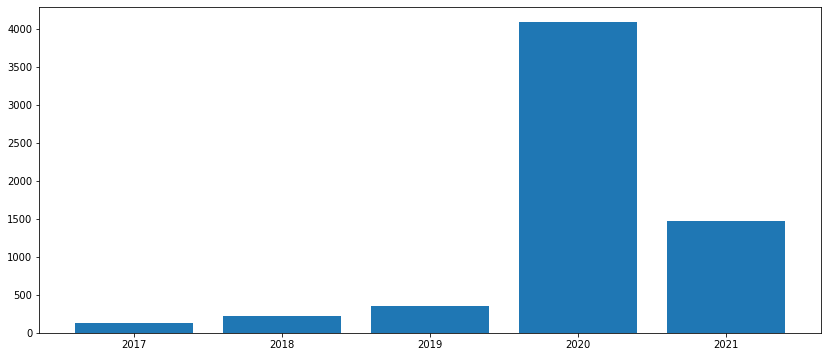

In [116]:
plt.bar(dict_date.keys(), dict_date.values())
plt.rcParams['figure.figsize'] = (14,6)
plt.show()

`Nous remarquons que la majorité de nos données proviennent de l'année 2020` 

### Nombre de caractères moyen par Tweet

In [106]:
nombre_caractere = [len(val) for val in df['Text']]

In [107]:
nombre_caractere_mean = sum(nombre_caractere)/len(nombre_caractere)

In [108]:
print("Nombre de caractères moyen par Tweets : {} ".format(int(nombre_caractere_mean)))

Nombre de caractères moyen par Tweets : 81 


### Nombre moyen de like par compte

In [109]:
mean_like = df.groupby(['user_name'])['Like'].mean()

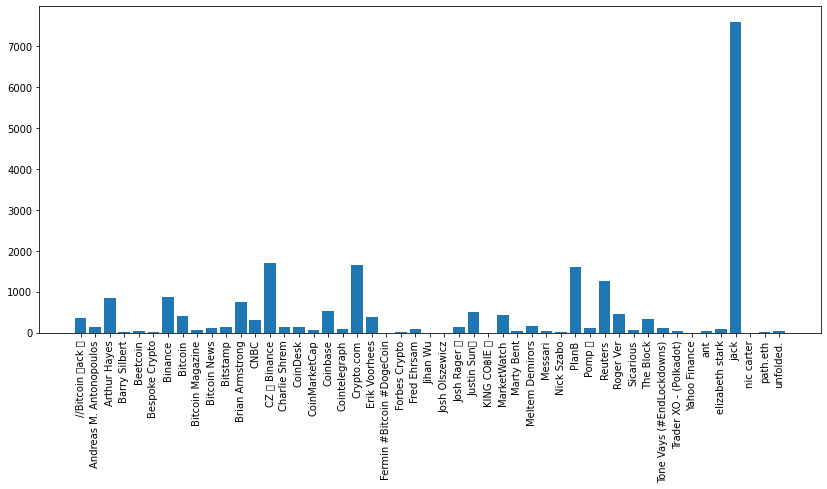

In [115]:
plt.bar(mean_like.index, mean_like)
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = (14,6)
plt.show()

Nous observons que le compte le plus liké est **@jack**. Ceci est intéressant dans le mesure où ce dernier est le créateur de Twitter et l'un des plus gros activistes au monde sur le Bitcoin.

### Contenu des 5 Tweets les plus likés

In [117]:
list_max = df.sort_values(['Like']).reset_index()['Text'][-5:]
for i in range(len(list_max)):
    print("Contenu Tweet {0} : {1}\n".format(i+1,list_max.values[i]))

Contenue Tweet 1 : presenting the th anniversary special btc at off on us m allocation no cro staking requir

Contenue Tweet 2 : running bitcoin

Contenue Tweet 3 : happy birthday bitcoin

Contenue Tweet 4 : want to build your btc position at off sept is your chance we ve allocated usd to

Contenue Tweet 5 : donate via bitcoin to help endsars



### Plot Rendements normalisés

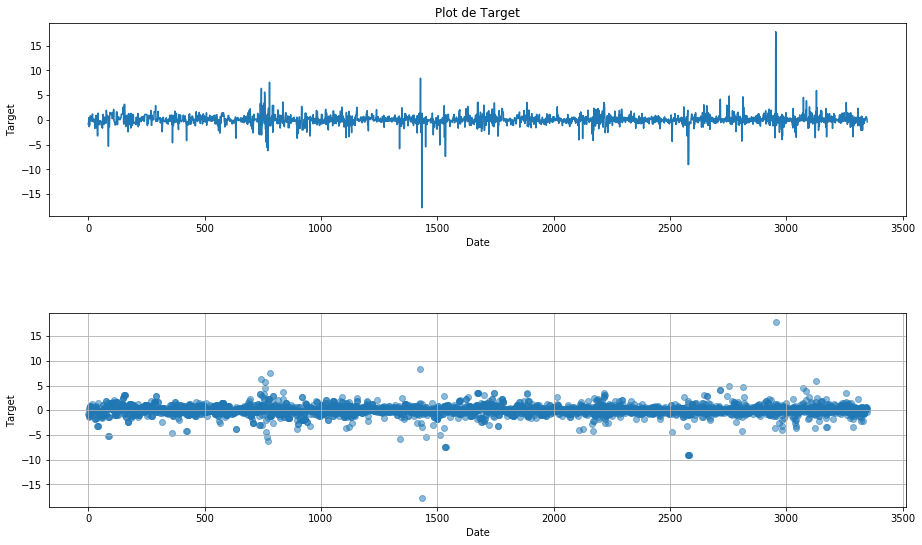

In [17]:
plt.subplot(211)
plt.plot(df['Target'])
plt.title("Plot de Target")
plt.ylabel('Target')
plt.xlabel('Date')

plt.subplot(212)
plt.scatter([i for i in range(len(df))],df['Target'], alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Target')

plt.grid(True)
plt.rcParams['figure.figsize'] = (14,6)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
plt.show()

## 4) NLP - BERT & Hugging Face

Brièvement, notre but ici est d'utiliser un algorithme de `Sentiment Analysis` associé à nos returns standardisés. Pour chaque nouveau Tweet, l'algorithme nous retournera un score qui sera une forme de `Sentiment Analysis` ayant appris des rendements qui sont associés à chaque Tweet. Notre objectif est de trouver des scores relativement élevés (en valeur absolue), ces derniers seront pour nous nos signaux d'achat ou de vente.

## Attention:

Nous conseillons de lancer la partie 4) sur **Google Colaboratory** pour pouvoir avoir accès à un GPU pour les calculs qui sont très importants (le temps de calcul passe de 1h30 à 4min en passant par un GPU). 

In [ ]:
!pip install transformers
!pip install torch
!pip install sklearn 

     |████████████████████████████████| 1.8MB 5.6MB/s 
     |████████████████████████████████| 2.9MB 19.7MB/s 
     |████████████████████████████████| 890kB 32.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=6f2b94166c1236346eb8964d53e8bddea5a6105807ec00188810da677a2056ec
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install transformers
!pip install torch
!pip install sklearn !pip install transformers
!pip install torch
!pip install sklearn 

#### Import des packages et GPU

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import scipy as sc
from transformers import BertModel, BertTokenizerFast, DistilBertForSequenceClassification, DistilBertTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import ShuffleSplit

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
Device name: Tesla K80


In [ ]:
df = pd.read_csv("tweets_price_df.csv") #set directory

#### Séparation des données en "train" et en "test"

In [ ]:
# Split our subset into random train and test subsets

import pandas as pd
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(list(df.Text), list(df["Target"]), train_size=.8, shuffle=False)

test = pd.DataFrame(list(zip(val_texts,list(df.Date[round(len(df)*0.8):]))))
test.head()

,0,1
0,we re only email address signups away to have ...,2020-10-24 17:00:00
1,bitcoin trends will firmly establish a don t b...,2020-10-24 17:00:00
2,bitcoin is pumping you want to quit your borin...,2020-10-22 14:00:00
3,thank you for strengthening the world s belief...,2020-10-19 17:00:00
4,the next industrial revolution is being tokeni...,2020-10-19 15:00:00


**Remarque:** Le choix de ne pas shuffle est en adéquation avec notre hypothèse de la temporalité des Tweets. En effet, nous estimons que mélanger le dataset dans notre cas n'avait pas de sens. De plus, cela aurait créé des problèmes lors de la phase de backtest de la stratégie. (Par exemple : si nous avions shuffle, nous aurions certainement backtester des Tweets déjà appris par le modèle).

In [ ]:
train= pd.DataFrame(list(zip(train_texts,list(df.Date))))
train.tail()

,0,1
2674,want to listen to a bunch of nerd girls and gu...,2020-11-02 13:00:00
2675,i put some bitcoin cards in my box of hallowee...,2020-11-01 06:00:00
2676,years ago satoshi nakamoto dropped a page bomb...,2020-10-31 17:00:00
2677,so crazy bitcoin will become a digital reserve...,2020-10-29 21:00:00
2678,microstrategy investment on bitcoin is alreay ...,2020-10-27 14:00:00


In [ ]:
train= pd.DataFrame(list(zip(train_texts,list(df.Date))))
train.tail()

#### Implémentation de BERT

Nous allons préparer la base de données de manière pratique pour le `trainer`  et la `tokenizé`:

Nous définissons nos labels dans un object dataset  en  utilisant `torch.utils.data.Dataset` et en implémentant `getitem` et `len`. De cette façon la donnée peut facilement être batchée. Ici, nous utilisons `DistilBert` qui est une version optimisée de `Bert` (avec moins de poids dans le réseau de neurones). De plus, `DistilBert` comme `Bert` contient une sémantique et une compréhension de la langue anglaise, grâce au pre-training effectué sur le modèle, à partir d'un corpus très volumineux de texte.
Nous allons utiliser `DistilBert Tokenizer` avant d'entrainer le modèle avec `pre-trained DistilBert`. On passe notre test dans le `tokenizer` avec `truncation = true` et `padding = true`. Ceci assure que nos séquences aient la même longueur et sont tronquées pour ne pas être plus longues que la longueur maximale de notre modèle.

In [ ]:
class DS(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
train_dataset = DS(train_encodings, train_labels)
val_dataset = DS(val_encodings, val_labels)

Ici nous n'avons plus qu'à créer notre modèle à "fine-tuner", définir notre `TrainingArguments` et instancier notre `Trainer`.

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy= "epoch"
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,1.551600,1.422059,1.470200,455.706000
2,3.398000,1.407920,1.458500,459.383000
3,0.780900,1.465223,1.460800,458.668000
4,0.782800,1.702835,1.462900,457.994000
5,0.389700,1.711355,1.450100,462.047000
6,0.174200,1.673108,1.467100,456.676000
7,0.403400,1.643242,1.464300,457.543000
8,0.298300,1.579392,1.473100,454.835000
9,0.242000,1.621821,1.471400,455.353000
10,0.094500,1.598756,1.463300,457.855000


TrainOutput(global_step=1680, training_loss=0.6798344016784713, metrics={'train_runtime': 298.0987, 'train_samples_per_second': 5.636, 'total_flos': 452013437330280, 'epoch': 10.0})

In [ ]:
test = [trainer.predict(DS(tokenizer([text], truncation=True, padding=True), [0])) for text in val_texts] 

### Résultats et interprétations :

Les résultats du réseau de neurones ne sont pas satisfaisants. En effet, nous pouvons voir (à travers un Run sur Google Colaboratory) que notre modèle est dans un cas typique de sur-apprentissage des données. En effet, à chacune des 10 époques, on voit que la `Training Loss` diminue mais que notre `Validation Loss` ne diminue pas, voire augmente. Comme cette dernière est bien supérieure à la `Training Loss`, notre modèle est bel et bien en train de sur-apprendre. En revanche, le modèle semble pouvoir détecter le sentiment lié à un Tweet traitant du Bitcoin. On peut même voir une sorte de granularité dans l'intensité des messages. Malheuresement, il semblerait que les prédictions ne permettent pas de donner des signaux d'achat/vente pertinents. Ce problème est très certainement la conséquence de notre hypothèse de base cherchant à distiller les informations à travers une requête croisée utilisateurs clés et hashtags. Cette hypothèse induit une trop faible quantité de données pour permettre au réseau d'apprendre correctement. Nous allons tout de même procéder au backtest et nous discuterons des solutions à apporter en conclusion. 

Voici quelques exemples sur certains Tweets pour comprendre comment `DistilBert` entrainé sur les rendements fonctionne :

In [11]:
test_oneshot = DS(tokenizer(["on bitcoin s th birthday satoshi nakamoto just became the th richest person in the world billion and counting"], truncation=True, padding=True), [0])
trainer.predict(test_oneshot)

PredictionOutput(predictions=array([[0.5800951]], dtype=float32), label_ids=array([0]), metrics={'eval_loss': 0.3365103304386139, 'eval_runtime': 0.0153, 'eval_samples_per_second': 65.439})

Ce Tweet est un exemple type de signal d'achat, et ceci paraît logique dans le sens où ce Tweet encense le Bitcoin.

In [12]:
test_oneshot = DS(tokenizer(["bitcoin aka crypto is direct activism against an unverifiable and exclusionary financial system which negative"], truncation=True, padding=True), [0])
trainer.predict(test_oneshot)

PredictionOutput(predictions=array([[0.01747653]], dtype=float32), label_ids=array([0]), metrics={'eval_loss': 0.0003054289845749736, 'eval_runtime': 0.0196, 'eval_samples_per_second': 51.017})

Cet exemple est très intéressant car on voit que `DistilBert` reste très neutre et donc ne nous donne aucune indication quant à un signal particulier. C'est un exemple typique où nous restons neutres sur le marché, soit en liquidité/cash (USDT).

In [35]:
test_oneshot = DS(tokenizer(["I am still bearish on bitcoin"], truncation=True, padding=True), [0])
trainer.predict(test_oneshot)

PredictionOutput(predictions=array([[-0.0162848]], dtype=float32), label_ids=array([0]), metrics={'eval_loss': 0.00026519468519836664, 'eval_runtime': 0.0145, 'eval_samples_per_second': 68.79})

Ici, l'information n'est pas assez conséquente pour pouvoir prendre une quelconque décision. Un trop court message n'est pas suffisant pour prendre une décision.

In [39]:
test_oneshot = DS(tokenizer(["i ve never before wished for bitcoin to crash but i hope we do so everyone can fill their bags last time for the"], truncation=True, padding=True), [0])
trainer.predict(test_oneshot)

PredictionOutput(predictions=array([[-0.13995264]], dtype=float32), label_ids=array([0]), metrics={'eval_loss': 0.01958674192428589, 'eval_runtime': 0.0149, 'eval_samples_per_second': 67.073})

Typiquement, nous pourrions nous mettre SHORT suite à ce Tweet mais il n'a pas assez d'intensité.

In [37]:
test_oneshot = DS(tokenizer(["tune in to binance blockchain week to hear from the top contender for bitcoin bull of the year"], truncation=True, padding=True), [0])
trainer.predict(test_oneshot)

PredictionOutput(predictions=array([[0.79102635]], dtype=float32), label_ids=array([0]), metrics={'eval_loss': 0.6257227063179016, 'eval_runtime': 0.0151, 'eval_samples_per_second': 66.373})

En revanche, ce Tweet est un exemple parfait de position LONG sur le Bitcoin.

En synthèse, ces exemples permettent de voir la granularité dont nous parlions précédement, mais certains messages sont interprétés comme positifs alors qu'ils ne devraient pas et inversement. De plus, lorsque le mot bitcoin n'apparait pas, l'algorithme retourne un sentiment totalement décorrélé du rendement, ce qui semble logique. Nous laissons l'utilisateur essayer d'autres exemples pour s'en appercevoir.

### Discussion et améliorations potentielles :

Nous pourrions imaginer une autre manière de scorer les Tweets. Par exemple, nous pourrions nous servir du nombre de likes relatifs d'un compte pour ajuster le score. Nous pourrions aussi donner des poids spécifiques à chacun des comptes en étudiant leurs importances au niveau de leurs posts qui ont été "re-Tweet". En revanche, ces améliorations demandent un travail de recherche approfondi sur la donnée du réseau social.

Pour une première approche, nous avons décidé d'aller droit au but et de conserver un modèle relativement simple et explicable, plutôt que de mélanger trop de données entre elles.

#### Récupération des signaux d'investissements

In [ ]:
signal = [test[i][0][0][0] for i in range(len(val_texts))]

#### Quelques statistiques

In [28]:
def Statistiques(variable):
    print("Statistiques :")
    return{
            "Mean": pd.Series(variable).mean(),
            "Max": max(variable),
            "Min": min(variable),
            "Var": np.var(variable),
            "Upper Bound": np.percentile(variable,70),
            "Lower Bound": np.percentile(variable,30)
            }

In [30]:
Statistiques(signal)

Statistiques :


{'Mean': 0.06022692398123965,
 'Max': 2.504241704940796,
 'Min': -1.8835374116897583,
 'Var': 0.1697464427221059,
 'Upper Bound': 0.2611275792121887,
 'Lower Bound': -0.12079136222600935}

#### Convertion des signaux en Dataframe

In [ ]:
signal_df = pd.DataFrame(list(zip(signal,list(df.Date[round(len(df)*0.8):]))), columns=['predict','Date'])
signal_df

,predict,Date
0,0.117567,2020-10-24 17:00:00
1,-0.368265,2020-10-24 17:00:00
2,0.493556,2020-10-22 14:00:00
3,0.632009,2020-10-19 17:00:00
4,-0.187218,2020-10-19 15:00:00
...,...,...
665,-0.184593,2020-02-21 03:00:00
666,-0.040151,2020-02-02 06:00:00
667,-0.252227,2019-08-09 19:00:00
668,0.596832,2019-02-06 07:00:00


In [ ]:
signal_df.to_csv('Signal_dataframe.csv')

In [ ]:
train_labels_df=pd.DataFrame(train_labels,columns=['Target'])

In [ ]:
train_labels_df.to_csv('Train_labels_dataframe.csv')

## 5) Backtest

### Description de la stratégie de Trading

La stratégie de trading est simple et conservatrice. Son objectif est de prendre des positions fortes sur le marché grâce à des signaux très intenses. Nous entendons par intenses des signaux d'achat (Long) qui sont supérieurs à un quantile à 70% sur la base de l'échantillon observé et entrainé (le train donc). Concernant les signaux de vente à découvert (Short), on cherche donc des signaux en dessous du quantile à 30%. Ainsi, lorsque le signal n'est pas assez fort, nous préférons rester en cash (USDT). L'idée est de laisser la position ouverte durant une heure (toujours d'après notre hypothèse précisée précédemment) et de couper la position (Take-profit). Le raisonnement de cette stratégie se base donc sur l'hypothèse que les Tweets impactants sont intégrés dans le prix sous une heure. Précisons une fois de plus que nous ne cherchons pas à estimer un rendement mais bel et bien un sens du marché. Le backtest qui est réalisé ici sera sur une période d'environ un mois.

In [5]:
data = pd.read_csv("price_df.csv")
prediction = pd.read_csv("Signal_dataframe.csv")
observations = pd.read_csv("Train_labels_dataframe.csv")

In [6]:
# Addition des predictions par heure, pour le cas de plusieurs predictions durant la même heure
prediction = prediction.groupby('Date')['predict'].apply(lambda x: sum(x))

#### Remarque : 
Nous avons décidé de sommer les signaux (et non pas de les moyenner) pour garder une notion d'intensité du signal. Prenons un exemple pour illustrer cette idée. Si plusieurs utilisateurs publient des Tweets dans la même heure sur le sujet, cela signifie que l'information est importante.

In [7]:
# on transforme prediction en dataframe
prediction = pd.DataFrame(prediction, columns= ['predict'])
prediction.reset_index(inplace=True)

In [8]:
prediction.head()

,Date,predict
0,2020-12-30 19:00:00,0.796467
1,2020-12-30 21:00:00,1.771327
2,2020-12-30 22:00:00,0.087391
3,2020-12-30 23:00:00,1.406058
4,2020-12-31 00:00:00,0.834686


In [9]:
# on récupère uniquement les données des prix a partir de la première date de prédiction
data = data[data['Date'] >= prediction['Date'][0]]

In [10]:
data.head()

,Unnamed: 0,Unnamed: 0.1,Date,Open,High,Low,Close,Volume,Close_time,Asset_volume,Trade_number,Target
29445,29445,0,2020-12-30 19:00:00,28239.68,28530.00,28239.68,28510.86,3992.536754,2020-12-30 19:59:59.999,1.133958e+08,73104,0.944010
29446,29446,0,2020-12-30 20:00:00,28510.86,28900.05,28444.00,28776.46,7242.879514,2020-12-30 20:59:59.999,2.081010e+08,119364,0.020602
29447,29447,0,2020-12-30 21:00:00,28776.45,28996.00,28603.24,28785.67,4271.327517,2020-12-30 21:59:59.999,1.230356e+08,81707,0.307049
29448,29448,0,2020-12-30 22:00:00,28785.67,28980.00,28534.70,28875.21,3551.040384,2020-12-30 22:59:59.999,1.022468e+08,77627,-0.621322
29449,29449,0,2020-12-30 23:00:00,28875.21,28903.93,28571.84,28703.88,1915.683224,2020-12-30 23:59:59.999,5.510670e+07,57210,0.601634


In [11]:
len(data)

885

In [12]:
# on joint les prix et prédictions
data2 = data.merge(prediction,how='left',on='Date')

In [13]:
# on remplace les 'NaN' par des zeros, soit on reste en cash sur la stratégie
data2['predict'] = data2['predict'].apply(lambda x: 0 if (str(x) == 'nan') else x)

In [23]:
class BackTrader:
    
    def __init__(self,data,set_cash,quantile):
        self.data = data
        self.set_cash = set_cash
        self.quantile = quantile
        self.observations = observations
        # Set et Initialiser le portefeuille
        self.portfolio = []
        self.portfolio.append(self.set_cash)
        # Set parametres plot
        self.settingP = { 'title'   : 'Portfolio',
                         'xlabel'  : 'Date',
                         'ylabel'  : 'Performance',
                         'figsize' : (14,6),
                         'size'    : '12'           }
        self.settingB = { 'title'   : 'Bitcoin',
                         'xlabel'  : 'Date',
                         'ylabel'  : 'Performance',
                         'figsize' : (14,6),
                         'size'    : '12'           }

 

    def strategy(self):
        # Parcours les prédictions
        for i in range(0,len(self.data)):
            if self.data['predict'][i] >= np.percentile(self.observations['Target'],100-self.quantile):
                gross_return = (self.data['Close'][i+1]/self.data['Close'][i]) - 1
                # Nouvelle performance du portefeuille sur 1H
                new_value_portfolio = self.portfolio[-1]*(1 + gross_return)
                # Ajouter la nouvelle valeur a portfolio
                self.portfolio.append(new_value_portfolio)

 

            elif self.data['predict'][i] <= np.percentile(self.observations['Target'],self.quantile):
                # Gross return sur 1H
                gross_return = (self.data['Close'][i+1]/self.data['Close'][i]) - 1
                # Nouvelle performance du portefeuille sur 1H
                new_value_portfolio = self.portfolio[-1]*(1 - gross_return)
                # Ajouter la nouvelle valeur a portfolio
                self.portfolio.append(new_value_portfolio)
        
            else:
                self.portfolio.append(self.portfolio[-1])
        
        return self.portfolio
    
    def plot_portfolio(self):
        plt.subplot(211)
        plt.title(self.settingP['title'])
        plt.plot(self.portfolio)
        plt.xlabel(self.settingP['xlabel'])
        plt.ylabel(self.settingP['ylabel'])
        plt.grid(True)
        
        
        plt.subplot(212)
        plt.title(self.settingB['title'])
        weight = self.set_cash/self.data['Close'][0]
        plt.plot([val*weight for val in self.data['Close']])
        plt.xlabel(self.settingB['xlabel'])
        plt.ylabel(self.settingB['ylabel'])
        plt.grid(True)
        
        plt.rcParams['figure.figsize'] = self.settingB['figsize']
        plt.rcParams["font.size"]= self.settingB['size']
        plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
        plt.show()

In [24]:
# Instanciation de la class BackTrader(data,Cash initial,quantile)
bt = BackTrader(data2,100000,30)

In [25]:
# Run la strategy backtesté sur 1 mois
portfolio = bt.strategy()

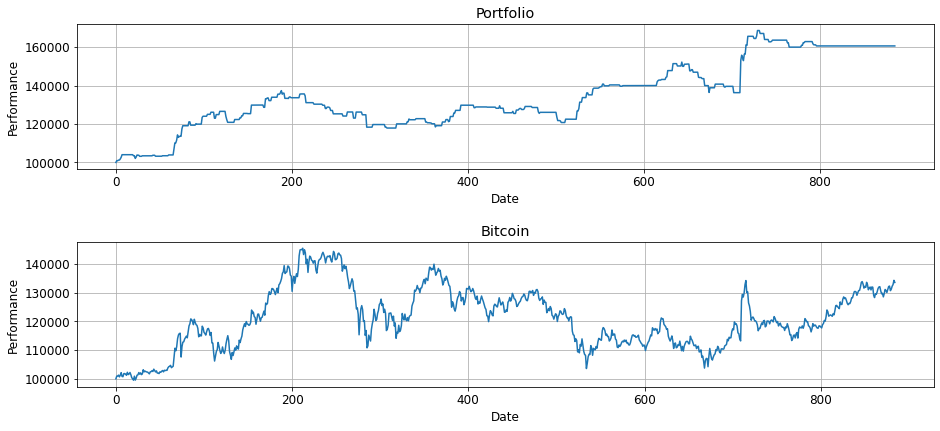

In [26]:
import matplotlib.pyplot as plt
# Plot les resultats
bt.plot_portfolio()

#### Remarque :
Ici, l'échelle de temps est la même, nous avons préféré laisser le nombre de prises de positions sur le marché pour notre portefeuille au cours du mois backtesté.

#### Statistiques de la stratégie

In [214]:
class PortfolioStatistics:
    
    def __init__(self, portfolio):
        self.portfolio = pd.Series(portfolio)

    def returns(self):
        returns= pd.Series(self.portfolio.shift(-1)/self.portfolio) - 1
        return returns
        
    def mean_return(self):
        mean_return = np.mean(self.returns())
        return mean_return
        
    def period_return(self):
        period_return = self.portfolio[len(self.portfolio)-1]/self.portfolio[0]-1
        return period_return
    
    def volatility(self):
        volatility = np.std(self.returns())* np.sqrt(len(self.portfolio))
        return volatility
    
    def sharpe_ratio(self):
        sharpe_ratio = self.period_return()/self.volatility()
        return sharpe_ratio
    
    def summary_stats(self):
        return {
        "Mean return": self.mean_return(),
        "Period's return": self.period_return(),
        "Volatility": self.volatility(),
        "Sharpe Ratio": self.sharpe_ratio()
        }

In [215]:
ps = PortfolioStatistics(portfolio)
ps.summary_stats()

{'Mean return': 0.002558161385490882,
 "Period's return": 0.6059073041270961,
 'Volatility': 0.22479168006588598,
 'Sharpe Ratio': 2.6954169475912364}

In [216]:
ps = PortfolioStatistics(data2['Close'])
ps.summary_stats()

{'Mean return': 0.00041704078656975804,
 "Period's return": 0.33497165641443294,
 'Volatility': 0.40015693487971066,
 'Sharpe Ratio': 0.8371007152859345}

### Résultats et interprétations :

La stratégie backtestée donne un résultat bien meilleur qu'attendu. Le rendement sur la période est près de deux fois supérieur au benchmark qui est le cours du Bitcoin. De plus, la contribution au rendement par unité de risque est bien plus large que celle du Bitcoin. En effet, notre stratégie a une volatilité près de deux fois inférieure à celle du Bitcoin. C'est la raison pour laquelle notre ratio de Sharpe est de $2.70$ quand celui du Bitcoin est de $0.83$. Notre stratégie reste donc conservatrice et performante. Cette sur-performance réside dans le fait que nous soyons majoritairement cash durant la période de backtest et que nous conservons mieux nos profits réalisés. C'est pourquoi on peut voir apparaître des paliers sur la courbe de notre backtest. Typiquement, on peut voir qu'aucun signal d'achat ou de vente n'est ressorti ces derniers jours.


## 5) Conclusion

Dans ce devoir nous avons essayé de mettre en oeuvre et d'appliquer tous les concepts vus dans le cours. En commençant par l'extraction de données via des API nous avons pu développer nos compétences sur le sujet. Par la suite, nous avons nettoyé et pre-processé les données de manière à pouvoir les utiliser avec notre outil de Machine Learning `DistilBert`. Avant de commencer, nous avons parcouru les données pour comprendre ce que nous avions récupéré et avoir des axes de réflexion pour développer notre projet. Par la suite, nous nous sommes servis de `DistilBert` pour pouvoir faire un Sentiment Analysis des Tweets en fonction des rendements standardisés associés. Ceci nous a permis de récupérer nos signaux et de pouvoir réaliser notre stratégie de Trading. Le backtest a bien été réalisé sur des données non-entrainées que nous avons conservées pour le Test.

Concernant les résultats, nous sommes surpris d'avoir une stratégie meilleure que le benchmark. En effet, rappelons que le réseau de neurones sur-apprend et que cela aurait pu induire de graves difficultés lors de la phase de backtest. Pour autant, cela n'a pas été le cas et la stratégie est performante. De plus, le cours du Bitcoin est sur une tendance haussière donc peut-être que cette performance est attribuée à un marché favorable. Ici, nous considérons cette performance dans un marché sans friction. Une critique majeure est que nous ne considérons pas les frais de transactions. Ces derniers sont trop variables d'une plateforme à l'autre mais également en fonction des montants. 

Pour finir, cette stratégie est prometteuse et pourrait se révéler efficace. Pour l'améliorer, il faudrait plus de données et peut-être réussir à créer un score qui prend en compte plus d'informations. Une autre amélioration possible serait d'optimiser la période de temps où l'information continue d'impacter le cours pour couper la position et take-profit à l'instant optimal. 